## Importações

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
from scipy import linalg
from tqdm import tqdm

## Conectar ao Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Constantes

In [ ]:
mnist_path = '/content/gdrive/MyDrive/Desafios_Tecnicos/fpftech/mnist_dataset'
epoch_samples_dir = '/content/gdrive/MyDrive/Desafios_Tecnicos/fpftech/mnist_gan_samples'
checkpoints_dir = '/content/gdrive/MyDrive/Desafios_Tecnicos/fpftech/mnist_gan_checkpoints'
models_dir = '/content/gdrive/MyDrive/Desafios_Tecnicos/fpftech/mnist_gan_models'

batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(epoch_samples_dir, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

## Funções Auxiliares

In [ ]:
def display_mnist_image(image_tensor, label=None):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    # Desnormalizar imagem: [-1, 1] to [0, 1]
    denormalized_image = (image_tensor * 0.5) + 0.5

    np_image = denormalized_image.squeeze().numpy()

    plt.imshow(np_image, cmap='gray')

    if label is not None:
        plt.title(f"Label: {label}")

    plt.axis('off')
    plt.show()

def sample_and_display_mnist(dataset, num_samples=5):
    for i in range(num_samples):
      image, label = dataset[i]
      display_mnist_image(image, label)

def save_generated_samples(G, epoch, fixed_z, fixed_labels, save_dir):
    G.eval()

    with torch.no_grad():
        fake_imgs = G(fixed_z, fixed_labels)

        # Voltar de [-1,1] -> [0,1] para visualizar
        fake_imgs = (fake_imgs + 1) / 2

        vutils.save_image(
            fake_imgs,
            f"{save_dir}/epoch_{epoch+1}.png",
            nrow=10
        )
    G.train()

def save_checkpoint(G, D, opt_G, opt_D, epoch, save_dir):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': G.state_dict(),
        'discriminator_state_dict': D.state_dict(),
        'opt_G_state_dict': opt_G.state_dict(),
        'opt_D_state_dict': opt_D.state_dict(),
    }, f"{save_dir}/cgan_epoch_{epoch+1}.pth")

def load_checkpoint(path, G, D, opt_G, opt_D):
    checkpoint = torch.load(path, map_location=device)

    G.load_state_dict(checkpoint['generator_state_dict'])
    D.load_state_dict(checkpoint['discriminator_state_dict'])
    opt_G.load_state_dict(checkpoint['opt_G_state_dict'])
    opt_D.load_state_dict(checkpoint['opt_D_state_dict'])

    return checkpoint['epoch']

def load_generator_from_checkpoint(checkpoint_path, G, device="cpu"):

    checkpoint = torch.load(checkpoint_path, map_location=device)

    G.load_state_dict(checkpoint['generator_state_dict'])
    G.to(device)
    G.eval()

    return G

def export_generator_to_torchscript(
    checkpoint_path, G, output_path="generator.pt", device="cpu", z_dim=100, num_classes=10):

    device = torch.device(device)

    # Carrega checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint['generator_state_dict'])
    G.to(device)
    G.eval()

    # Exemplo de entrada (para o trace da rede)
    example_noise = torch.randn(1, z_dim, device=device)
    example_labels = torch.zeros(1, dtype=torch.long, device=device)

    # Converte para TorchScript
    scripted_G = torch.jit.trace(G, (example_noise, example_labels))

    # Salva
    torch.jit.save(scripted_G, output_path)

def load_generator_torchscript(model_path, device="cpu"):
    device = torch.device(device)
    model = torch.jit.load(model_path, map_location=device)
    model.eval()
    return model

## Preparar Dataset MNIST

In [ ]:
# Transform de normalizacao
transform = transforms.Compose([
    transforms.ToTensor(), # [0,255] to [0,1]
    transforms.Normalize((0.5,), (0.5,)) # [0,1] to [-1,1]
])

# Baixar dataset
dataset = datasets.MNIST(
    root=mnist_path,
    train=True,
    download=True,
    transform=transform
)

# Criar dataloader
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)


## Arquitetura das Redes Generator e Discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, n_classes=10, embed_dim=50):
        super().__init__()

        # Vetores de embeddings (um vetor por digito) que sera aprendido para representar cada digito dentro da rede
        self.label_emb = nn.Embedding(n_classes, embed_dim)

        # Estrutura da rede
        self.model = nn.Sequential(
            # Entrada: ruido + informação da classe; Saida: 128 maps de 7x7 (vetorizado)
            nn.Linear(z_dim + embed_dim, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7), # Normalizacao
            nn.ReLU(True), # Nao lineariedade

            # Transforma vetor em feature maps (128 maps de 7x7)
            nn.Unflatten(1, (128, 7, 7)),

            # Upsample: 7x7 -> 14x14; Canais: 128 -> 64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample: 14x14 -> 28x28; Canais: 64 -> 1
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),

            # Saída em [-1,1] para combinar com normalização do dataset
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Converte label em embedding
        label_vec = self.label_emb(labels)

        # Concatena ruido + classe
        x = torch.cat([z, label_vec], dim=1)

        # Gera a imagem
        img = self.model(x)
        return img

class Discriminator(nn.Module):
    def __init__(self, n_classes=10, img_size=28):
        super().__init__()

        # Embedding transforma label em mapa espacial
        # Cada classe vira um "canal" auxiliar da imagem
        self.label_emb = nn.Embedding(n_classes, img_size * img_size)

        self.model = nn.Sequential(
            # Entrada agora tem 2 canais: imagem + mapa do label
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3), # Adicionar dropout para estabilidade

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
        )

    def forward(self, images, labels):
        # Transforma label em mapa 28x28
        label_map = self.label_emb(labels) # [batch_size, 784]
        label_map = label_map.view(labels.size(0), 1, 28, 28) # [batch_size, 1, 28, 28]

        # Concatena imagem com o mapa da classe
        x = torch.cat([images, label_map], dim=1) # [batch_size, 2, 28, 28]

        # Inferencia
        validity = self.model(x)
        return validity



## Treinamento

In [ ]:
# Funcao de inicializacao dos Pesos
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator().to(device)
D = Discriminator().to(device)

G.apply(weights_init)
D.apply(weights_init)

# Funcao de Loss
criterion = nn.BCEWithLogitsLoss()

# Otimizadores
lr = 0.0002
betas = (0.5, 0.999)
opt_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

# Gerando ruido e labels fixos (para comparar a evolucao entre as epocas)
fixed_z = torch.randn(10, 100, device=device)
fixed_labels = torch.arange(0, 10, device=device) # 0-9


In [ ]:
def train_cgan(G, D, dataloader, epochs=100, z_dim=100):
    G.train()
    D.train()

    for epoch in range(epochs):
        epoch_loss_D = 0.0
        epoch_loss_G = 0.0
        num_batches = 0

        for batch_idx, (real_imgs, labels) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            # Label smoothing para estabilidade
            real_targets = torch.ones(batch_size, 1, device=device) * 0.9  # 0.9 em vez de 1.0
            fake_targets = torch.zeros(batch_size, 1, device=device)

            # ============================================
            # Treinar Discriminador
            # ============================================
            opt_D.zero_grad()

            # Imagens reais
            real_preds = D(real_imgs, labels)
            loss_real = criterion(real_preds, real_targets)

            # Imagens falsas
            z = torch.randn(batch_size, z_dim, device=device)
            fake_imgs = G(z, labels)
            fake_preds = D(fake_imgs.detach(), labels) # detach() impede gradiente de ir pro G
            loss_fake = criterion(fake_preds, fake_targets)

            loss_D = (loss_real + loss_fake) / 2  # Media para balancear
            loss_D.backward()
            opt_D.step()

            # ============================================
            # Treinar Gerador
            # ============================================
            opt_G.zero_grad()

            z = torch.randn(batch_size, z_dim, device=device)
            fake_imgs = G(z, labels)
            preds = D(fake_imgs, labels)

            loss_G = criterion(preds, real_targets)  # G quer enganar D
            loss_G.backward()
            opt_G.step()

            # ============================================
            # Logs
            # ============================================
            if batch_idx % 100 == 0:
                print(
                    f"[Epoch {epoch+1}/{epochs}] "
                    f"[Batch {batch_idx}/{len(dataloader)}] "
                    f"Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}"
                )

            epoch_loss_D += loss_D.item()
            epoch_loss_G += loss_G.item()
            num_batches += 1

        # Media das losses da epoca
        avg_loss_D = epoch_loss_D / num_batches
        avg_loss_G = epoch_loss_G / num_batches

        print(f"\n=============================================================")
        print(f"Epoca {epoch+1}/{epochs} concluida")
        print(f"Loss D media: {avg_loss_D:.4f} | Loss G media: {avg_loss_G:.4f}")
        print(f"=============================================================\n")

        # Salvar amostras
        save_generated_samples(G, epoch, fixed_z, fixed_labels, epoch_samples_dir)

        # Salvar checkpoint
        if (epoch + 1) % 10 == 0:
            save_checkpoint(G, D, opt_G, opt_D, epoch, checkpoints_dir)

In [ ]:
train_cgan(G, D, dataloader, epochs=100, z_dim=100)

## Salvando Modelo

In [ ]:
G_net = Generator().to(device)
export_generator_to_torchscript(
    f"{checkpoints_dir}/cgan_epoch_80.pth",
    G_net,
    output_path=f"{models_dir}/cgan_generator_epoch_80.pt",
    device=device,
    z_dim=100, num_classes=10)

## Testando Modelo

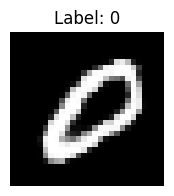

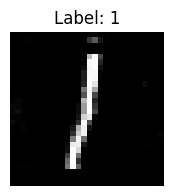

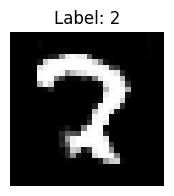

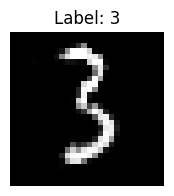

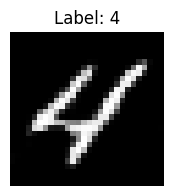

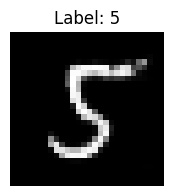

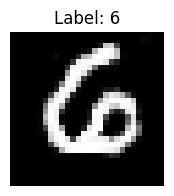

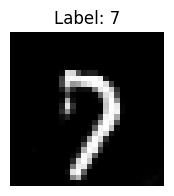

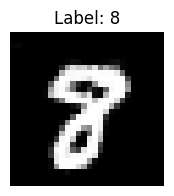

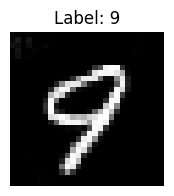

In [ ]:
G_eval = load_generator_torchscript(f"{models_dir}/cgan_generator_epoch_80.pt", device="cpu")

with torch.no_grad():
    for n in range(10):
      noise = torch.randn(1, 100, device="cpu")
      label = torch.tensor([n], device="cpu")
      image = G_eval(noise, label)
      display_mnist_image(image, n)

## Avaliando Modelo

In [ ]:
# Modelo Inception v3: Extrator de features transforma uma imagem em um vetor de características semanticas
class InceptionFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        inception = models.inception_v3(pretrained=True, transform_input=False) # carrega o extrator de features
        inception.fc = torch.nn.Identity() # substitui a camada final por uma função identidade, assim mantem apenas features
        self.model = inception.to(device).eval()

    @torch.no_grad()
    def forward(self, x):
        return self.model(x)

# Imagem MNIST -> Formato Inception v3
def preprocess_for_inception(x):
    x = x.repeat(1, 3, 1, 1)
    # o modelo inception espera uma entrada de 299x299
    x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
    x = (x + 1) / 2
    return x

# Extrair features de imagens reais e features de imagens geradas pelo Generator
def extract_features(generator, dataloader, n_samples=10000, z_dim=100):
    extractor = InceptionFeatureExtractor()
    real_feats, fake_feats, logits = [], [], []

    generator.eval()

    with torch.no_grad():
        for real_imgs, labels in tqdm(dataloader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            z = torch.randn(real_imgs.size(0), z_dim, device=device)
            fake_imgs = generator(z, labels)

            real_p = preprocess_for_inception(real_imgs)
            fake_p = preprocess_for_inception(fake_imgs)

            real_f = extractor(real_p).cpu().numpy()
            fake_f = extractor(fake_p).cpu().numpy()

            real_feats.append(real_f)
            fake_feats.append(fake_f)
            logits.append(fake_f)

            if len(np.concatenate(fake_feats)) >= n_samples:
                break

    return np.concatenate(real_feats), np.concatenate(fake_feats), np.concatenate(logits)


# Transforma vetores de features em uma distribuicao
def get_stats(features):
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma


# Calculo do Frechet Inception Distance: distancia entre as distribuicoes real vs fake(imagens do generator)
def calculate_fid(real_feats, fake_feats):
    mu_r, sigma_r = get_stats(real_feats)
    mu_f, sigma_f = get_stats(fake_feats)

    diff = mu_r - mu_f
    covmean = linalg.sqrtm(sigma_r @ sigma_f)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_r + sigma_f - 2 * covmean)
    return fid

# Calculo do Inception Score:
# mede a qualidade: se as imagens geradas sao nitidas e se parecem com um objeto especifico
# mede a diversidade: se o gerador produz uma ampla variedade de imagens
def calculate_inception_score(logits, splits=10):
    preds = F.softmax(torch.tensor(logits), dim=1).numpy()
    scores = []

    for k in range(splits):
        part = preds[k * len(preds)//splits : (k+1) * len(preds)//splits]
        py = np.mean(part, axis=0)
        kl = part * (np.log(part + 1e-10) - np.log(py + 1e-10))
        scores.append(np.exp(np.mean(np.sum(kl, axis=1))))

    return np.mean(scores), np.std(scores)

def evaluate_gan(generator, dataloader):

    print("Extraindo features das imagens...")
    real_feats, fake_feats, logits = extract_features(generator, dataloader)

    print("Calculando FID...")
    fid = calculate_fid(real_feats, fake_feats)

    print("Calculando Inception Score...")
    is_mean, is_std = calculate_inception_score(logits)

    print("\n===== RESULTADOS =====")
    print(f"FID: {fid:.2f}")
    print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")


In [ ]:
G = Generator().to(device)
load_generator_from_checkpoint(f"{checkpoints_dir}/cgan_epoch_80.pth", G, device)
evaluate_gan(G, dataloader)

Extraindo features das imagens...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 17%|█▋        | 78/469 [01:12<06:02,  1.08it/s]


Calculando FID...
Calculando Inception Score...

===== RESULTADOS =====
FID: 8.36
Inception Score: 1.04 ± 0.00
